Datasets and shapefile loaded successfully!
Downsampled mobile sensor readings: 50000
Downsampled static sensor readings: 50000


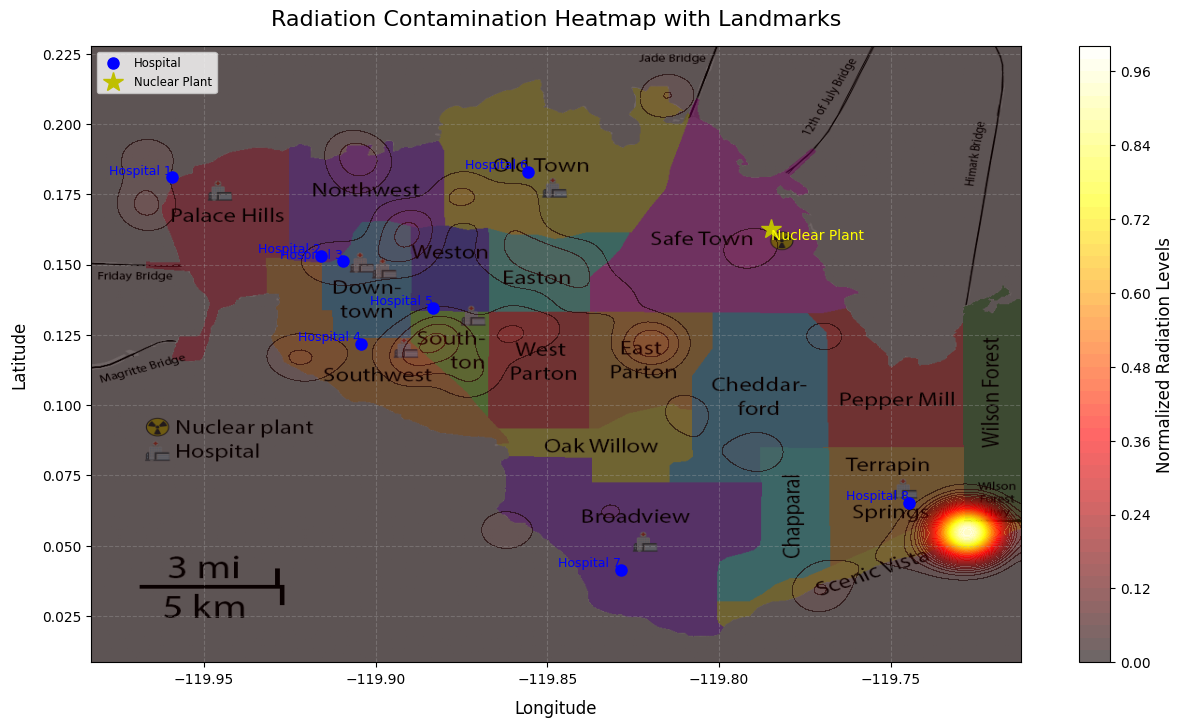

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.ndimage import gaussian_filter
from shapely.geometry import Point

# Load datasets
def load_datasets():
    mobile_data = pd.read_csv('MobileSensorReadings.csv')
    static_data = pd.read_csv('StaticSensorReadings.csv')
    static_locations = pd.read_csv('StaticSensorLocations.csv')
    wind_data = pd.read_csv('WindDirection.csv')
    neighborhoods = gpd.read_file('StHimarkNeighborhoodShapefile/StHimark.shp')

    # Ensure the shapefile has a proper CRS (Coordinate Reference System)
    neighborhoods = neighborhoods.to_crs(epsg=4326)  # Convert to WGS84 (Lat/Long)
    print("Datasets and shapefile loaded successfully!")
    return mobile_data, static_data, static_locations, wind_data, neighborhoods

# Preprocess data
def preprocess_data(mobile_data, static_data, wind_data, row_limit=50000):
    # Convert timestamps to datetime
    mobile_data['Timestamp'] = pd.to_datetime(mobile_data['Timestamp'])
    static_data['Timestamp'] = pd.to_datetime(static_data['Timestamp'])
    wind_data['Timestamp'] = pd.to_datetime(wind_data['Timestamp'])

    # Drop missing or invalid values
    mobile_data = mobile_data.dropna(subset=['Value', 'Long', 'Lat'])
    static_data = static_data.dropna(subset=['Value'])

    # Filter for significant radiation values
    mobile_data = mobile_data[mobile_data['Value'] > 0]
    static_data = static_data[static_data['Value'] > 0]

    # Limit rows for faster processing
    mobile_data = mobile_data.sample(min(len(mobile_data), row_limit), random_state=42)
    static_data = static_data.sample(min(len(static_data), row_limit), random_state=42)
    print(f"Downsampled mobile sensor readings: {len(mobile_data)}")
    print(f"Downsampled static sensor readings: {len(static_data)}")

    return mobile_data, static_data, wind_data

# Associate wind data with mobile data
def associate_wind_data(mobile_data, wind_data):
    wind_data = wind_data.sort_values('Timestamp')
    mobile_data = mobile_data.sort_values('Timestamp')
    mobile_data = pd.merge_asof(mobile_data, wind_data, on='Timestamp', direction='nearest')
    return mobile_data

# Gaussian Plume Model
def gaussian_plume(Q, u, sigma_y, sigma_z, distance):
    try:
        return (Q / (2 * np.pi * u * sigma_y * sigma_z)) * np.exp(-distance**2 / (2 * sigma_y**2))
    except Exception as e:
        print(f"Error in Gaussian Plume calculation: {e}")
        return np.zeros_like(distance)

# Create heatmap
def create_heatmap(mobile_data, neighborhoods, grid_size=200):
    # Extract bounds from shapefile
    bounds = neighborhoods.total_bounds  # [minx, miny, maxx, maxy]
    x_min, y_min, x_max, y_max = bounds

    # Define grid
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x, y)
    heatmap = np.zeros_like(X, dtype=np.float32)

    # Iterate through mobile sensor data
    for _, row in mobile_data.iterrows():
        Q = row['Value']  # Emission rate
        sensor_x, sensor_y = row['Long'], row['Lat']
        wind_speed = row['wind speed']
        if np.isnan(wind_speed) or wind_speed == 0:
            continue

        # Calculate Gaussian kernel
        sigma = 0.005  # Adjust kernel width
        distances = (X - sensor_x) ** 2 + (Y - sensor_y) ** 2
        gaussian = Q * np.exp(-distances / (2 * sigma**2))
        heatmap += gaussian

    # Normalize and smooth heatmap
    heatmap = gaussian_filter(heatmap, sigma=3)
    heatmap[heatmap < 0] = 0  # Handle invalid values
    heatmap = heatmap / np.max(heatmap)  # Normalize to [0, 1]
    return X, Y, heatmap

# Overlay heatmap with improved visualization and hover effect
# Overlay heatmap with enhanced visualization
def overlay_heatmap(X, Y, heatmap, neighborhoods, hospitals, nuclear_plant, image_path):
    # Load base map image
    base_map = plt.imread(image_path)

    # Get bounds from shapefile
    x_min, y_min, x_max, y_max = neighborhoods.total_bounds

    # Plot heatmap
    plt.figure(figsize=(15, 8))
    plt.imshow(base_map, extent=[x_min, x_max, y_min, y_max], aspect='auto')
    heatmap_plot = plt.contourf(X, Y, heatmap, levels=50, cmap='hot', alpha=0.6)

    # Add colorbar
    cbar = plt.colorbar(heatmap_plot)
    cbar.set_label('Normalized Radiation Levels', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Add hospitals with labels
    for idx, (lat, lon) in enumerate(hospitals):
        plt.plot(lon, lat, 'bo', markersize=8, label='Hospital' if idx == 0 else "")
        plt.text(lon, lat, f'Hospital {idx + 1}', fontsize=9, color='blue', ha='right', va='bottom')

    # Add nuclear plant with label
    plt.plot(nuclear_plant[1], nuclear_plant[0], 'y*', markersize=15, label='Nuclear Plant')
    plt.text(nuclear_plant[1], nuclear_plant[0], 'Nuclear Plant', fontsize=10, color='yellow', ha='left', va='top')

    # Customize plot
    plt.title('Radiation Contamination Heatmap with Landmarks', fontsize=16, pad=15)
    plt.xlabel('Longitude', fontsize=12, labelpad=10)
    plt.ylabel('Latitude', fontsize=12, labelpad=10)
    plt.legend(loc='upper left', fontsize='small', frameon=True)
    plt.grid(alpha=0.3, linestyle='--')

    plt.show()

# Main workflow
if __name__ == "__main__":
    # Load datasets and shapefile
    mobile_data, static_data, static_locations, wind_data, neighborhoods = load_datasets()

    # Preprocess data
    mobile_data, static_data, wind_data = preprocess_data(mobile_data, static_data, wind_data, row_limit=50000)

    # Associate wind data with mobile data
    mobile_data = associate_wind_data(mobile_data, wind_data)

    # Create heatmap
    X, Y, heatmap = create_heatmap(mobile_data, neighborhoods, grid_size=200)

    # Landmarks
    hospitals = [
        (0.180960, -119.959400), (0.153120, -119.915900), (0.151090, -119.909520),
        (0.121800, -119.904300), (0.134560, -119.883420), (0.182990, -119.855580),
        (0.041470, -119.828610), (0.065250, -119.744800)
    ]
    nuclear_plant = (0.162679, -119.784825)

    # Overlay heatmap
    overlay_heatmap(X, Y, heatmap, neighborhoods, hospitals, nuclear_plant, "StHimarkNeighborhoodMap.png")
